# **Transformers Pre-Training: Masked Language Modeling**
---

- Implementing Encoder-Only Transformer model
- Preparing the dataset from scratch
- Training BERT-like tokenizer from scratch
- Training from scratch with MLM objective
- Trained on Wikipedia dataset from scratch

# Imports
---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import random
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Training Tokenizer
---

In [2]:
with open('/kaggle/input/wikipedia-sentences/wikisent2.txt','r') as f:
    lines = f.read().split('\n')
    lines = random.choices(lines,k=100_000)
    lines = [ln for ln in lines if len(ln)>1]
    train_lines, val_lines = train_test_split(lines,test_size=0.1,shuffle=True)
    val_lines, test_lines = train_test_split(val_lines,test_size=0.2,shuffle=True)
    
len(lines), len(train_lines), len(val_lines), len(test_lines)

(100000, 90000, 8000, 2000)

In [3]:
bert_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
bert_tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()

trainer = WordPieceTrainer(special_tokens=["[UNK]","[PAD]", "[MASK]"],vocab_size=8192)
bert_tokenizer.train_from_iterator(lines,trainer)
bert_tokenizer.enable_padding(pad_id=bert_tokenizer.token_to_id('[PAD]'),length=128)
bert_tokenizer.enable_truncation(128)

base = Path('mlm-baby-bert/tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'wiki.json'))

In [4]:
tokenizer = Tokenizer.from_file(str(base/'wiki.json'))

In [5]:
a = tokenizer.encode('this is a sample text! Shreyas')
for i,t in zip(a.ids,a.tokens):
    print(f'{i}:{t} ',end=' ')
tokenizer.decode(a.ids)

361:this  153:is  40:a  4164:samp  176:##le  2958:text  3:!  3951:shr  416:##ey  145:##as  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  1:[PAD]  

'this is a sample text! shreyas'

In [6]:
tokenizer.token_to_id("[UNK]"),tokenizer.token_to_id("[PAD]"),tokenizer.token_to_id("[MASK]")

(0, 1, 2)

# Preparing Dataset
---

- in Masked Language Modeling, the loss calculation is similar to that of causalLMs
- the inputs and the labels are identical in terms of position
- in the inputs:
    - 15% of the tokens are masked / replaced randomly by the `[MASK]` token
    - this 15% doesn't include the pad tokens
- in the labels:
    - the ground-truth tokens which were masked in the inputs are present in the labels
    - all other tokens are ignored (set to -100) by the default behaviour of nn.CrossEntropyLoss    

In [7]:
class MLMDataset:
    def __init__(self,lines):
        self.lines = lines
    def __len__(self,):
        return len(self.lines)
    def __getitem__(self,idx):
        line = self.lines[idx]
        ids = tokenizer.encode(line).ids
        labels = ids.copy()
        return ids, labels

In [8]:
def collate_fn(batch):
    input_ids = [torch.tensor(i[0]) for i in batch]
    labels = [torch.tensor(i[1]) for i in batch]
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels)
    # mask 15% of text leaving [PAD]
    mlm_mask = torch.rand(input_ids.size()) < 0.15 * (input_ids!=1)
    masked_tokens = input_ids * mlm_mask
    labels[masked_tokens==0]=-100 # set all tokens except masked tokens to -100
    input_ids[masked_tokens!=0]=2 # MASK TOKEN
    return input_ids, labels

In [9]:
ds = MLMDataset(lines)
dl = torch.utils.data.DataLoader(ds,batch_size=2,shuffle=True,collate_fn=collate_fn)

## this is how a sample looks
---

In [10]:
i,l = next(iter(dl))
print(i[1])
print(l[1])

tensor([5680,   10,  313,    2,    2, 4541,   14, 5393, 5404,   70,   11,  153,
          40, 2319,    2, 7560,   14, 1681, 3534,  148, 1649,   16,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])
tensor([-100, -100, -100,  939, 1058, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, 1246, -100, -100, -100, -100, -100, -100, -

# Encoder-Only Transformer Model
---

- straightforward simple implementation.
- nn.LayerNorm replaced with RMSNorm which is preferred to by many.
- It looks like BERT but it is not BERT. BERT is more complicated than this.
- Only implementing the MLM part of BERT so no need of [CLS] and [SEP] tokens
- Learned positional embeddings instead of sinusoidal in BERT.
- We can have a mask for the encoder self-attention as well by masking out the pad tokens so attention layers ignore the extra stuff.
- For inference currently only supports batch size of 1.
- After the encoder outputs pass through the `dim->vocab` Linear layer, the logits at the position where the token was masked are softmaxed and then with argmax the token that's supposed to be there is predicted.

```
out: 1 x 128 x 256
if the input sequence for inference was masked at position 4, we extract 1 x 256 at index 4:
preds: out[:,4,:]
softmax -> argmax
preds: predicted token
```

In [11]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

In [12]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.in_proj = nn.Linear(dim,dim*3,bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim,dim)
        
    def forward(self,x,mask=None):
        b,t,c = x.shape
        q,k,v = self.in_proj(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_dim).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_dim).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_dim).permute(0,2,1,3)
        
        qkT = torch.matmul(q,k.transpose(-1,-2)) * self.scale
        qkT = self.attn_dropout(qkT)
        
        if mask is not None:
            mask = mask.to(dtype=qkT.dtype,device=qkT.device)
            qkT = qkT.masked_fill(mask==0,float('-inf'))
              
        qkT = F.softmax(qkT,dim=-1)
        attn = torch.matmul(qkT,v)
        attn = attn.permute(0,2,1,3).contiguous().view(b,t,c)
        out = self.out_proj(attn)
        
        return out

In [13]:
class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim)
        )
        
    def forward(self, x):
        return self.feed_forward(x)

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        
    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x

In [15]:
class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x

In [16]:
class MLMBERT(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        
        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])
        
        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        
        self.ln_f = RMSNorm(config['dim'])
        
        self.mlm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)
        
        self.embedding.class_embedding.weight = self.mlm_head.weight # weight tying
        
        self.pad_token_id = config['pad_token_id']
        self.mask_token_id = config['mask_token_id']
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len
    
    def forward(self,input_ids,labels=None):
        
        src_mask = self.create_src_mask(input_ids)
        enc_out = self.embedding(input_ids)
        for layer in self.encoders:
            enc_out = layer(enc_out,mask=src_mask)
        
        enc_out = self.ln_f(enc_out)
        
        logits = self.mlm_head(enc_out)
        
        if labels is not None:
            loss = F.cross_entropy(logits.view(-1,logits.size(-1)),labels.view(-1))
            return {'loss': loss, 'logits': logits}
        else:
            # assuming inference input_ids only have 1 [MASK] token
            mask_idx = (input_ids==self.mask_token_id).flatten().nonzero().item()
            mask_preds = F.softmax(logits[:,mask_idx,:],dim=-1).argmax(dim=-1)
            return {'mask_predictions':mask_preds}

# Training Preparation
---

In [17]:
config = {
    'dim': 256,
    'n_heads': 8,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 6,
    'vocab_size': 8192,
    'max_len': 128,
    'pad_token_id': 1,
    'mask_token_id': 2
}

In [18]:
model = MLMBERT(config).to('cuda')
print('trainable:',sum([p.numel() for p in model.parameters() if p.requires_grad]))

trainable: 6861056


In [19]:
train_ds = MLMDataset(train_lines)
val_ds = MLMDataset(val_lines)

In [20]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

## Calculating accuracy by masking only 1 token
---

- Not a great metric but I wanted something basic to begin with.

In [21]:
# TEST : SINGLE TOKEN MASKING

test_actuals = []
test_batches = []
for ln in tqdm(test_lines):
    tokenized = tokenizer.encode(ln)
    fi = len(tokenized.ids)
    if 1 in tokenized.special_tokens_mask:
        fi = torch.tensor(tokenized.special_tokens_mask).nonzero()[0].item() # ignore [PAD]
    m = torch.randint(0,fi,(1,)).item() # select random token to mask
    input_ids = torch.tensor(tokenized.ids)
    test_actuals.append(input_ids[m].item())
    input_ids[m]=2 # replace with [MASK]
    test_batches.append(input_ids)

  0%|          | 0/2000 [00:00<?, ?it/s]

# Training
---

In [22]:
epochs = 100
train_losses = []
valid_losses = []
test_accuracies = []
best_val_loss = 1e9

In [23]:
optim = torch.optim.Adam(model.parameters(),lr=6e-4 / 25.)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=6e-4,steps_per_epoch=len(train_dl),epochs=epochs)

In [24]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, (input_ids, labels) in tprog:
        input_ids = input_ids.to('cuda')
        labels = labels.to('cuda')
        loss = model(input_ids,labels)['loss']
        loss.backward()
        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))
        
    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, (input_ids, labels) in vprog:

            input_ids = input_ids.to('cuda')
            labels = labels.to('cuda')
            loss = model(input_ids,labels)['loss']
            vrl += loss.item()
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
        if vloss < best_val_loss:
            best_val_loss = vloss
            print('PREDICTING!')
            test_predictions = []
            for input_ids in tqdm(test_batches):
                input_ids = input_ids.unsqueeze(0)
                input_ids = input_ids.to('cuda')
                mask_preds = model(input_ids)['mask_predictions']
                test_predictions.extend(list(mask_preds.detach().cpu().flatten().numpy()))
            
            tacc = accuracy_score(test_actuals, test_predictions)
            test_accuracies.append(tacc)
            print(f'SINGLE MASK TOKEN PREDICTION ACCURACY: {tacc:.4f}')
            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./mlm-baby-bert/model.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 0 | train_loss: 7.6729 valid_loss: 7.1071
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.0735
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 1 | train_loss: 7.0118 valid_loss: 6.9389
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1005
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 2 | train_loss: 6.9014 valid_loss: 6.8574
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1095
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 3 | train_loss: 6.8291 valid_loss: 6.7642
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1340
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 4 | train_loss: 6.7031 valid_loss: 6.6189
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1505
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 5 | train_loss: 6.4938 valid_loss: 6.3138
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1725
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 6 | train_loss: 6.0884 valid_loss: 5.7905
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2100
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 7 | train_loss: 5.6595 valid_loss: 5.4835
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2290
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 8 | train_loss: 5.3554 valid_loss: 5.2276
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2585
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 9 | train_loss: 5.1507 valid_loss: 5.0403
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2820
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 10 | train_loss: 4.9542 valid_loss: 4.8273
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2960
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 11 | train_loss: 4.7652 valid_loss: 4.6901
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3005
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 12 | train_loss: 4.6052 valid_loss: 4.5427
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3190
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 13 | train_loss: 4.4592 valid_loss: 4.3782
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3415
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 14 | train_loss: 4.3340 valid_loss: 4.2656
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3535
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 15 | train_loss: 4.2128 valid_loss: 4.2039
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3595
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 16 | train_loss: 4.1053 valid_loss: 4.0985
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3790
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 17 | train_loss: 4.0008 valid_loss: 4.0286
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3790
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 18 | train_loss: 3.9240 valid_loss: 3.9578
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3895
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 19 | train_loss: 3.8465 valid_loss: 3.8812
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3965
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 20 | train_loss: 3.7821 valid_loss: 3.8803
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4075
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 21 | train_loss: 3.7145 valid_loss: 3.8034
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4070
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 22 | train_loss: 3.6593 valid_loss: 3.7659
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4130
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 23 | train_loss: 3.6166 valid_loss: 3.7388
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4245
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 24 | train_loss: 3.5501 valid_loss: 3.7085
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4205
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 25 | train_loss: 3.5177 valid_loss: 3.6442
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4285
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 26 | train_loss: 3.4789 valid_loss: 3.6767


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 27 | train_loss: 3.4487 valid_loss: 3.6085
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4375
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 28 | train_loss: 3.4037 valid_loss: 3.5766
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4495
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 29 | train_loss: 3.3688 valid_loss: 3.5494
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4515
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 30 | train_loss: 3.3341 valid_loss: 3.5273
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4345
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 31 | train_loss: 3.2982 valid_loss: 3.5334


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 32 | train_loss: 3.2751 valid_loss: 3.5013
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4500
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 33 | train_loss: 3.2442 valid_loss: 3.4460
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4510
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 34 | train_loss: 3.2092 valid_loss: 3.4613


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 35 | train_loss: 3.1939 valid_loss: 3.4129
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4620
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 36 | train_loss: 3.1573 valid_loss: 3.4585


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 37 | train_loss: 3.1368 valid_loss: 3.4179


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 38 | train_loss: 3.1087 valid_loss: 3.3995
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4685
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 39 | train_loss: 3.0931 valid_loss: 3.3627
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4645
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 40 | train_loss: 3.0632 valid_loss: 3.3703


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 41 | train_loss: 3.0398 valid_loss: 3.3201
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4840
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 42 | train_loss: 3.0200 valid_loss: 3.3312


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 43 | train_loss: 3.0008 valid_loss: 3.3260


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 44 | train_loss: 2.9685 valid_loss: 3.3083
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4780
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 45 | train_loss: 2.9545 valid_loss: 3.2588
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4760
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 46 | train_loss: 2.9316 valid_loss: 3.2811


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 47 | train_loss: 2.9086 valid_loss: 3.2947


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 48 | train_loss: 2.8921 valid_loss: 3.2392
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4865
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 49 | train_loss: 2.8690 valid_loss: 3.2232
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4875
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 50 | train_loss: 2.8528 valid_loss: 3.1972
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4925
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 51 | train_loss: 2.8286 valid_loss: 3.2130


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 52 | train_loss: 2.8129 valid_loss: 3.2315


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 53 | train_loss: 2.7812 valid_loss: 3.1862
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4955
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 54 | train_loss: 2.7684 valid_loss: 3.2132


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 55 | train_loss: 2.7426 valid_loss: 3.1659
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5125
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 56 | train_loss: 2.7295 valid_loss: 3.1501
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5055
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 57 | train_loss: 2.7060 valid_loss: 3.1524


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 58 | train_loss: 2.6883 valid_loss: 3.1237
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5095
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 59 | train_loss: 2.6649 valid_loss: 3.1033
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5135
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 60 | train_loss: 2.6363 valid_loss: 3.1090


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 61 | train_loss: 2.6238 valid_loss: 3.1029
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5105
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 62 | train_loss: 2.6014 valid_loss: 3.1263


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 63 | train_loss: 2.5828 valid_loss: 3.0975
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5160
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 64 | train_loss: 2.5682 valid_loss: 3.0969
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5220
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 65 | train_loss: 2.5446 valid_loss: 3.0845
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5180
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 66 | train_loss: 2.5133 valid_loss: 3.1063


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 67 | train_loss: 2.4982 valid_loss: 3.0753
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5220
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 68 | train_loss: 2.4806 valid_loss: 3.0397
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5255
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 69 | train_loss: 2.4631 valid_loss: 3.0620


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 70 | train_loss: 2.4427 valid_loss: 3.0562


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 71 | train_loss: 2.4234 valid_loss: 3.0214
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5325
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 72 | train_loss: 2.3982 valid_loss: 3.0304


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 73 | train_loss: 2.3851 valid_loss: 3.0482


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 74 | train_loss: 2.3660 valid_loss: 3.0251


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 75 | train_loss: 2.3456 valid_loss: 3.0120
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5280
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 76 | train_loss: 2.3270 valid_loss: 3.0058
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5395
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 77 | train_loss: 2.3186 valid_loss: 2.9962
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5325
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 78 | train_loss: 2.2967 valid_loss: 3.0215


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 79 | train_loss: 2.2835 valid_loss: 3.0122


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 80 | train_loss: 2.2754 valid_loss: 2.9686
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5410
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 81 | train_loss: 2.2660 valid_loss: 2.9945


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 82 | train_loss: 2.2457 valid_loss: 2.9870


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 83 | train_loss: 2.2394 valid_loss: 3.0028


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 84 | train_loss: 2.2306 valid_loss: 3.0000


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 85 | train_loss: 2.2247 valid_loss: 2.9663
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5455
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 86 | train_loss: 2.2034 valid_loss: 2.9811


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 87 | train_loss: 2.1956 valid_loss: 2.9839


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 88 | train_loss: 2.1930 valid_loss: 2.9701


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 89 | train_loss: 2.1796 valid_loss: 2.9816


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 90 | train_loss: 2.1733 valid_loss: 2.9633
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5460
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 91 | train_loss: 2.1705 valid_loss: 2.9755


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 92 | train_loss: 2.1606 valid_loss: 2.9604
PREDICTING!


  0%|          | 0/2000 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.5475
saving best model...


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 93 | train_loss: 2.1672 valid_loss: 2.9677


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 94 | train_loss: 2.1607 valid_loss: 2.9903


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 95 | train_loss: 2.1584 valid_loss: 2.9720


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 96 | train_loss: 2.1530 valid_loss: 2.9753


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 97 | train_loss: 2.1584 valid_loss: 2.9666


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 98 | train_loss: 2.1629 valid_loss: 2.9848


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

epoch 99 | train_loss: 2.1597 valid_loss: 2.9770


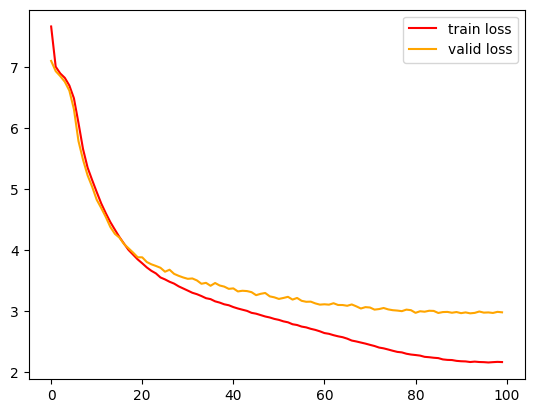

In [25]:
plt.plot(train_losses,color='red',label='train loss')
plt.plot(valid_losses,color='orange',label='valid loss')
plt.legend()
plt.show()

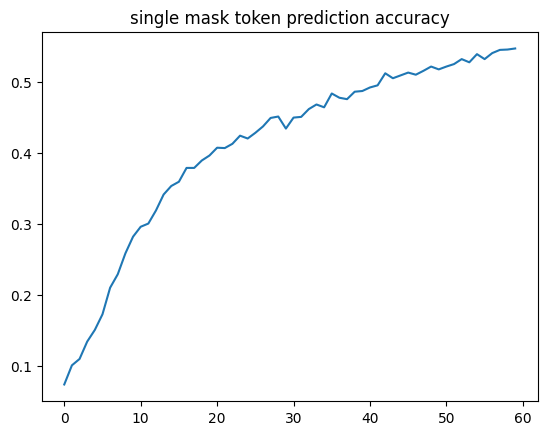

In [26]:
plt.plot(test_accuracies)
plt.title('single mask token prediction accuracy')
plt.show()

In [27]:
# best model
sd = torch.load('./mlm-baby-bert/model.pt')
model.load_state_dict(sd)

<All keys matched successfully>

In [28]:
def predict_mask(sentence):
    
    x = tokenizer.encode(sentence)
    
    # picking an index to mask, range: [0,len-1]
    fi = len(x.ids)
    # if the sample contains pad tokens, we can't mask them, so limiting the end index to ignore padding
    if 1 in x.special_tokens_mask:
        fi = torch.tensor(x.special_tokens_mask).nonzero()[0].item() # ignore [PAD]
    # random index to mask
    idx = torch.randint(0,fi,(1,)).item()
    
    input_ids = x.ids.copy()
    masked_token = tokenizer.decode([input_ids[idx]])
    
    # masking
    input_ids[idx] = 2 # idx -> [MASK]
    masked_sentence = input_ids.copy()
    
    # preparing input
    input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
    
    # extracting the predicted token
    out = model(input_ids)
    predicted = x.ids.copy()
    predicted[idx] = out['mask_predictions'].item()
    predicted_token = tokenizer.decode([out['mask_predictions'].item()])
    
    print(f'masked: {masked_token} predicted: {predicted_token}')
    masked_sentence = tokenizer.decode(masked_sentence,skip_special_tokens=False)
    masked_sentence = masked_sentence.replace('[PAD]','')
    print('ACTUAL:',sentence)
    print('MASKED:',masked_sentence)
    print(' MODEL:',tokenizer.decode(predicted))
    
    return int(masked_token == predicted_token)

In [29]:
correct = 0
for sentence in random.choices(train_lines+test_lines,k=100):
    correct += predict_mask(sentence)
    print('\n\n')
print(f'CORRECT:{correct}/{100}')

masked: . predicted: .
ACTUAL: Made Out of Babies and the former lead singer of defunct post-metal supergroup Battle of Mice.
MASKED: made out of babies and the former lead singer of defunct post - metal supergroup battle of mice [MASK]                                                                                                        
 MODEL: made out of babies and the former lead singer of defunct post - metal supergroup battle of mice.



masked: ##e predicted: ##e
ACTUAL: In California, when mounted and riding on the road, cyclists are required to "behave like vehicles" when it comes to obeying signals, signage, and lane restrictions.
MASKED: in california, when mounted and riding on the road, cyclists are required to " behav [MASK] like vehicles " when it comes to obeying signals, signage, and lane restrictions.                                                                                       
 MODEL: in california, when mounted and riding on the road, cyclists are required

# Conclusion
---

- Needs more metrics suitable for this.
- Maybe will try finetuning this model for downstream tasks later in the future.
- Inference should work for batch_size > 1, but I have limited time to work on this, this gets the job done.
- Follow for more stuff like this on [Kaggle](https://kaggle.com/shreydan) and [GitHub](https://github.com/shreydan)
- Comment your thoughts on how I could've done things differently.
- Upvote if you found it helpful!
- See you around

## Thank you :)

```
Your word is a lamp to my feet and a light to my path. Psalm 119:105
```